# **Data Visualisation**

## Objectives

Business requirement 1:
- Analysis on average images and variability images for each class (healthy or powdery mildew).
- Analysis on the differences between average healthy and average powdery mildew cherry leaves.
- Image montage for each class.

## Inputs

- The images will be extracted from the - **train**, **test** & **validation** - folders which are located in inputs/cherryleaves_dataset/cherry-leaves.
- These images will also be taken from the 2 further folders - **healthy** & **powdery_mildew**.

## Outputs

- Finding the average image sizes in the **train** set, and then ensuring all images have the equivalent sizing as the determined CNN structure size.
- Image shape embeddings saved as a pickle file.
- Plotting the mean and variability of images per label.
- Plotting to differentiate the disparity between the healthy leaves and the mildew infected leaves.
- Generate code that answers the business requirement 1 and can be used to build an image montage on the Streamlit dashboard.

## Addition Comments

- These steps are esential to prepare the data that will be presented to the CNN. 
- The data is also visually organised for the client.

---

## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Change Working Directory

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection-in-cherry-leaves/jupyter_notebooks'

In [3]:
os.chdir('/workspace/mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection-in-cherry-leaves'

## Setting Input Directories

In [5]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Setting Output Directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available. Create a new version.')
    pass
else:
    os.makedirs(name=file_path)

## Setting Labels

In [7]:
labels = os.listdir(train_path)
print('Labelling for the images are', labels)

Labelling for the images are ['healthy', 'powdery_mildew']


---

# **Image Data**

## Image Shaping

- Calculate the average image sizes on the **train** set

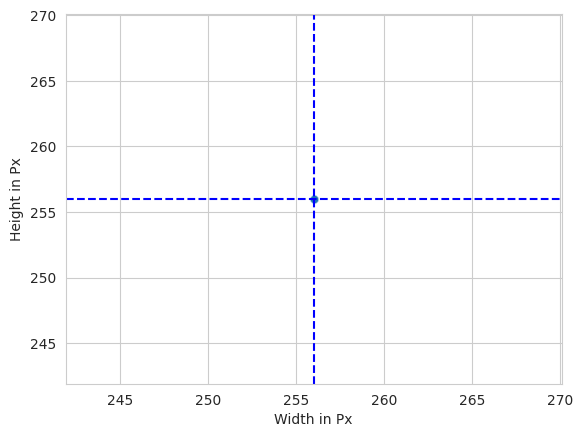

Width average: 256 
Height average: 256


In [13]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # height
        dim2.append(d2)  # width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.4)
axes.set_xlabel("Width in Px")
axes.set_ylabel("Height in Px")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='b', linestyle='--')
axes.axhline(y=dim2_mean, color='b', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

- Sizes for training the model is the average from all the images in the **train** set.

In [14]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

- Saving the images with the shape embeddings.

In [15]:
joblib.dump(value=image_shape,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']